1. Initialize road capacity matrix, with the number 0 to represent residential areas and
   the number 2-5 to represent roads with different widths. Also initialize
   traffic volume distribution matrix with the same dimension, initialized to
   all 0, regarded as no traffic volume.
2. Partial cells are selected randomly according to density and generation rules
   to randomly generate trafffic flows.
3. Determine the destination for each unit of traffic flow.
4. According to parallel and nearest rule (distance) and conflict avoidance, the
   traffic flows are updated. When an iteration is complete, generate a new
   traffic flow and add it to the matrix.
5. Repeat steps 3-4 until the traffic flow matrix the maximum number of
   iterations have transpired.
6. The traffic distribution in the ciry at each timestep and the traffic
   trajectory generated at different time steps are output.

In [38]:
import seaborn as sns
from PIL import Image
from traffic_sim.matrix import TrafficMatrix

<AxesSubplot:>

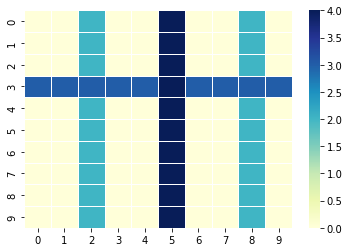

In [39]:
tm = TrafficMatrix(10, 10)
# set traffic capacities (hardcoded)
tm.cmatrix[:, 2] = 2
tm.cmatrix[:, 8] = 2
tm.cmatrix[3, :] = 3
tm.cmatrix[:, 5] = 4
tm.run(5)
sns.heatmap(tm.cmatrix, cmap="YlGnBu", linewidth=0.5)

<AxesSubplot:>

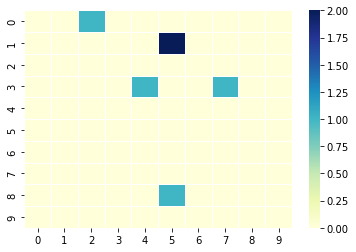

In [40]:
sns.heatmap(tm.vmatrix, cmap="YlGnBu", linewidth=0.5)

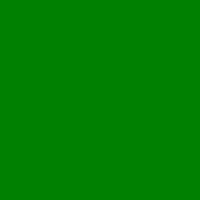

In [43]:
im = Image.new("RGB", (200, 200), "green")
im.save("test.png")
im